<center><img src="./images/logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center><br/>

# ML through Application 
## Module 3, Lab 2, Notebook 1: Exploring Data for Bias

This notebook shows you how to look for bias in data by quantifying and visualizing correlations (scatterplots and correlation matrices) and by generating descriptive statistics (histograms). You will also see how to use the class imbalance ($CI_{norm}$) and difference in proportion of positive labels ($DPL$) metrics. When you build an ML model, you want to try as many metrics as possible to look for bias.

You will learn how to do the following:
- Create scatterplots.
- Create correlation matrices.
- Calculate class imbalance (CI) and difference in proportion of labels (DPL).

__Dataset:__ 
You will use [Folktables](https://github.com/zykls/folktables) to download a dataset for this lab. Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files, which the U.S. Census Bureau manages. The data itself is governed by the terms of use that are provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html). 

You will filter the ACS PUMS data sample to include only individuals who are above the age of 16, reported usual working hours of at least 1 hour per week in the past year, and have an income of at least \\$100. 
The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable replacement to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult), but the income threshold can be changed easily to define new prediction tasks. Historically, the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) served as the basis for the development and comparison of many algorithmic fairness interventions but has limited documentation, outdated feature encodings, and only contains a binary target label which can lead to misrepresentations for certain subpopulations. In order to compare your results with scientific findings that utilize the UCI Adult dataset, and to have greater control and flexibility in setting up the problem, you will utilize the ACS PUMS data with the filters and thresholds described above.

__ML problem:__ 
The goal is to predict whether an individual's income is above \\$50,000. 
This is a binary prediction task that can enable organizations and businesses to target their marketing efforts more effectively. Alternatively, governments could leverage these predictions to design better social welfare programs and allocate resources efficiently. Keep these kinds of problems in mind, when working through the notebook.

Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

----

You will be presented with activities throughout the notebook: <br/>

|<img style="float: center;" src="./images/activity.png" alt="Activity" width="125"/>| 
| --- | 
|<p style="text-align:center;"> No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p>|

## Index

- [Loading data](#Loading-data)
- [Basic data processing](#Basic-data-processing)
- [Bar plots and histograms](#Bar-plots-and-histograms)
- [Scatterplots](#Scatterplots)
- [Correlation matrices](#Correlation-matrices)
- [DPL and CI](#DPL-and-CI)

Before loading in the dataset, make sure to install and import all required libraries.

In [1]:
# Use pip to install libraries
!pip install --no-deps -U -q -r requirements.txt

In [2]:
# Import the libraries needed for the notebook

# Reshaping/basic libraries
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set default seaborn color scheme
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Operational libraries
from MLUMLA_EN_M3_Lab2_quiz_questions import *

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


---
## Loading data

To read in the dataset, you will use [Folktables](https://github.com/zykls/folktables), as described earlier in this lab. Folktables contains predefined prediction tasks but also allows the user to specify the problem type.

The U.S. Census Bureau dataset distinguishes between households and individuals. To obtain data on individuals, you will use `ACSDataSource` with `survey="person"`. The feature names for the data follow the same distinction, and use *P* for person and *H* for household. For example, AGEP refers to the age of an individual.

In [3]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grandparents living with grandchildren
    "SCH",  # school enrollment
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

---
## Basic data processing

First, you want to go through basic steps of exploratory data analysis (EDA) to perform initial data investigations to discover patterns, spot anomalies, and look for insights to inform later ML modeling choices.

In [4]:
# Convert NumPy array to DataFrame
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,SCH,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,1.0,0.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,52.0,NaN,2.0,0.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,33.0,2.0,1.0,0.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,53.0,2.0,1.0,0.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,106.0,NaN,3.0,0.0


In [5]:
# Check how many rows and columns are in the DataFrame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (195665, 14)


In [6]:
# See the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  float64
 1   COW     195665 non-null  float64
 2   SCHL    195665 non-null  float64
 3   MAR     195665 non-null  float64
 4   OCCP    195665 non-null  float64
 5   POBP    195665 non-null  float64
 6   RELP    195665 non-null  float64
 7   WKHP    195665 non-null  float64
 8   SEX     195665 non-null  float64
 9   RAC1P   195665 non-null  float64
 10  PWGTP   195665 non-null  float64
 11  GCL     149392 non-null  float64
 12  SCH     195665 non-null  float64
 13  >50k    195665 non-null  float64
dtypes: float64(14)
memory usage: 20.9 MB


Notice that all columns are numerical (`dtype = float64`). However, check the column headers (and information about the dataset from the links given at the beginning of the notebook), and notice that you are actually dealing with multimodal data. The dataset has a mix of categorical, numerical, and potentially even text information.

Cast the features accordingly.

In [7]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
    "SCH",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

You might also notice the unintuitive feature names. With a few exceptions, it is difficult to understand what the features refer to. For example, MAR could refer to March, but in this dataset it encodes marital status. It could be worthwhile to rename the features so that it will be easier to understand what they refer to. You can do this by creating a renaming dictionary and using the Pandas `.rename()` method.

Example of feature renaming:
```
# Create dictionary for new column names
rename_dict = {"COW":"worker_class", "SCHL":"educational_attainment"} 

# Apply new names to DataFrame
df.rename(rename_dict, axis=1, inplace=True)
```

In [8]:
# Cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# Cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  int64  
 1   COW     195665 non-null  object 
 2   SCHL    195665 non-null  object 
 3   MAR     195665 non-null  object 
 4   OCCP    195665 non-null  object 
 5   POBP    195665 non-null  object 
 6   RELP    195665 non-null  object 
 7   WKHP    195665 non-null  int64  
 8   SEX     195665 non-null  object 
 9   RAC1P   195665 non-null  object 
 10  PWGTP   195665 non-null  int64  
 11  GCL     149392 non-null  object 
 12  SCH     195665 non-null  object 
 13  >50k    195665 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 20.9+ MB


To make sure that the changes took effect, use `.info()` to check. Compare the results to the `df.info()` output above to make sure the features were cast correctly. 

Now you can separate model features from the model target to explore them separately. 

### Model target and model features

In [10]:
# Define the name of the target column you want to make predictions for
model_target = ">50k"
# Combine the categorical and numerical features
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'SCH', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [11]:
# Check that the target is not accidentally part of the features
model_target in model_features

False

This looks good. You made sure that the target is not in the feature list. If the output of the previous cell is `True`, you need to remove the target by calling `model_features.remove(model_target)`.

Next, you want to start creating some visualizations of the data that you are working with.

Before starting with the plots, look at how many unique instances you have per column. This helps you avoid plotting charts with hundreds of unique values. To do this, filter for columns with fewer than 10 unique categories.

In [12]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    9.0
GCL      2.0
SCH      3.0
dtype: float64


---
## Bar plots and histograms

In this section, you examine the data with plots. 

__Important:__ These plots ignore null (missing) values. As you saw in the previous section, only one column in the dataset contains NA values: GCL (grandparents living with grandchildren).

For plotting, you need to distinguish between plots for categorical data (bar plots) and plots for numerical data (histograms and scatterplots):

* __Bar plots:__ These plots show counts of categorical data fields. The `value_counts()` function yields the counts of each unique value. To turn the value count into a plot, add `.plot.bar()`.

* __Histograms:__ Histograms show distributions of numeric data. Data is divided into buckets or bins. Use histograms for numerical data to group data points together into buckets. The command to create a histogram is `df[feature_name].plot.hist(bins=5)`.

### Bar plots
The features that are eligible for bar plots are all categorical features, including the target (which is also a binary categorical value). First, look at the distribution of the model target.

#### Target distribution

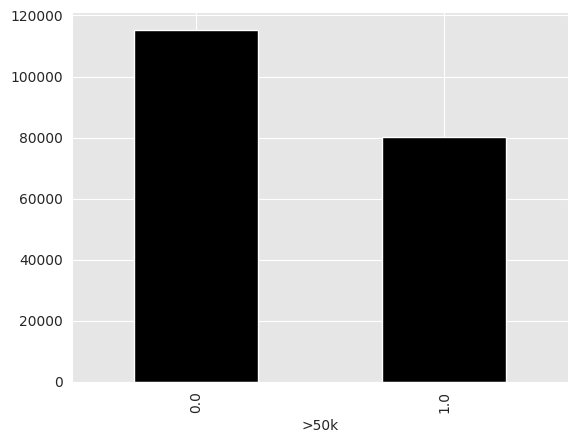

In [14]:
# Create a bar plot of showing the number of counts that 
# are 1 or 0 based on the >50k model_target
df[model_target].value_counts().plot.bar(color="black")
plt.show()

Keep in mind that you eventually want to build a model that can consider different groups. The sensitive attribute for this example will be the RAC1P feature.

Now plot a similar chart, but include another dimension (the outcome). To do this, you need to group by the feature that you want to encode. You also want to stack the bar chart to be able to compare it to the bar chart from the previous cell. To do this, you will set the `alpha` transparency value below 1 to better see the horizontal grid lines of the plot background.

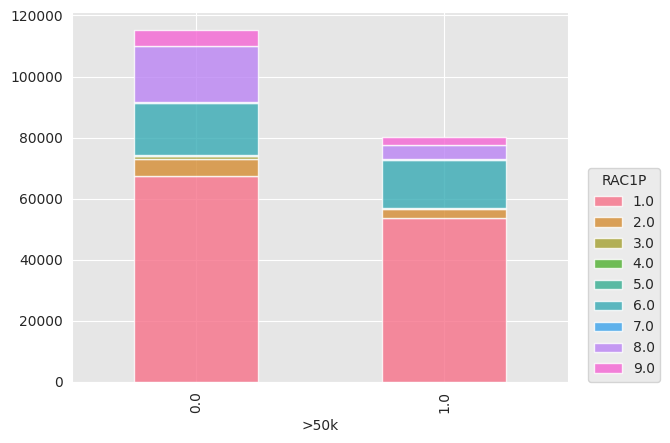

In [15]:
# Set color map for the different categories
cmap = sns.set_palette("husl", 9)

# Perform grouping based on target and feature
df.groupby([model_target, "RAC1P"])["RAC1P"].count().unstack().plot(
    kind="bar", stacked=True, alpha=0.8
)

# Add legend
plt.legend(loc=(1.04, 0), title="RAC1P")
plt.show()

#### Feature distribution

Now you can start to explore other features (so far, you only looked at the distribution of the target). The first feature that you might want to explore could be the sensitive attribute itself. It can be helpful to know how many groups are in a sensitive feature column and how many instances there are per group.

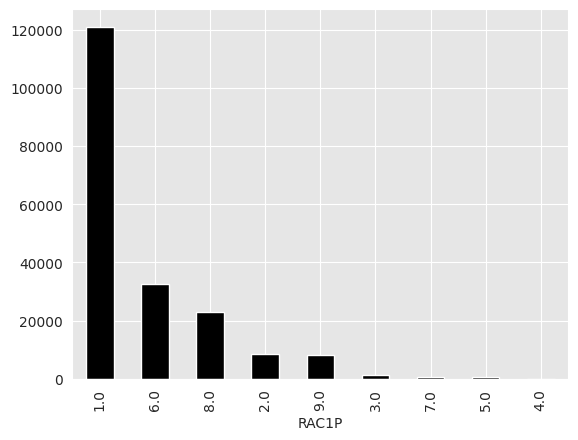

In [16]:
df["RAC1P"].value_counts().plot.bar(color="black")
plt.show()

Now plot the same chart, but include another dimension. For this, you want to use another library, Seaborn. Seaborn has a method called `countplot()` that allows you to pass a DataFrame and feature columns as well as an additional column to use for color encoding.

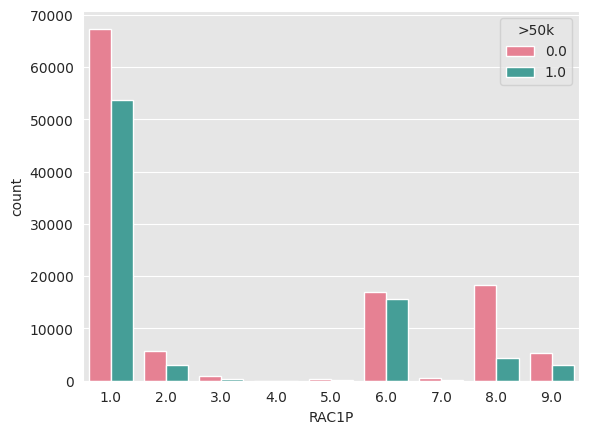

In [17]:
# Plot RAC1P on the x-axis and get counts; in addition, color is based on model target category
sns.countplot(x="RAC1P", hue=model_target, data=df, palette="husl", dodge=True)

plt.show()

Convert these bar charts to percentage numbers to compare the groups more directly. Ultimately, you want to dive deeper into the groups with the biggest differences.

In [18]:
# Group by RAC1P feature and count
perc_df = pd.DataFrame(df.groupby("RAC1P")[model_target].value_counts()).rename(
    {model_target: "count"}, axis=1
)

# Calculate percentage total
perc_df["count"] / perc_df.groupby("RAC1P")["count"].transform("sum")

RAC1P  >50k
1.0    0.0     0.556634
       1.0     0.443366
2.0    0.0     0.655136
       1.0     0.344864
3.0    0.0     0.716383
       1.0     0.283617
4.0    0.0     0.615385
       1.0     0.384615
5.0    0.0     0.786667
       1.0     0.213333
6.0    0.0     0.519490
       1.0     0.480510
7.0    0.0     0.701727
       1.0     0.298273
8.0    0.0     0.805730
       1.0     0.194270
9.0    0.0     0.642822
       1.0     0.357178
Name: count, dtype: float64

In [19]:
print("Sum of individuals in group 6:",perc_df["count"][6].sum())
print("Sum of individuals in group 8:",perc_df["count"][8].sum())

Sum of individuals in group 6: 32709
Sum of individuals in group 8: 22793


Notice that the outcome is not equally distributed across all RAC1P categories. The biggest discrepancy appears to be category 8. This group has almost four times as many instances of income $\leq$ 50k as above 50k. Group 8 has 22,793 individuals. If you compare this to group 6 (with 32,709 individuals), you should notice that the distribution of outcomes is different there, with an almost 50/50 split for the income levels.


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">If you wanted to create a countplot for another feature, what would be the correct code snippet?</p>
    <p style=" text-align: center; margin: auto;">(Ideally, you want to use a feature that you don't expect to be a contributing factor to the outcome, such as grandparents living with grandchildren.)</p>
    <br>
    <p style=" text-align: center; margin: auto;">To answer the question, run the following cell.</p>
    <br>
</div>

In [21]:
# Run this cell for a knowledge check question
question_1

You can create another type of bar plot by using `.catplot()`. With this method, you can specify three dimensions of encoding at the same time. You can specify the feature that you want _counts_ for (for example, count of how many instances there are for each job category), generate comparison columns by using a second feature, and encode the outcome as color.

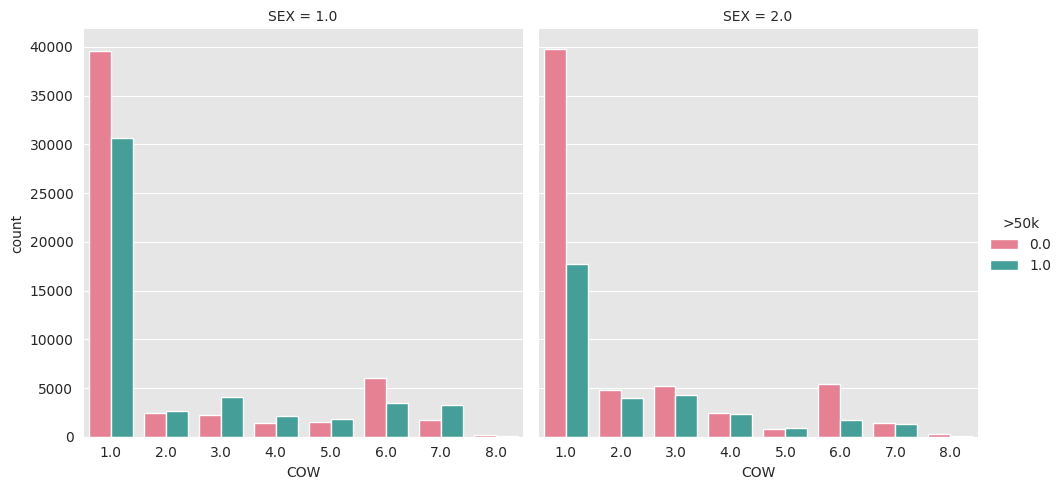

In [22]:
sns.catplot(x="COW", col="SEX", kind="count", hue=model_target, data=df, palette="husl")
plt.show()

The data has been divided by SEX into two charts. Each chart shows the number of people who make greater than 50k compaired to those who make less than 50k for each work class. You can observe a pay difference by sex and also by work class (job family).

### Histograms

Histograms show distributions of numeric data. Data is divided into buckets or bins. Use histograms for numerical data to group data points together into buckets. The command to create a histogram is `df[<feature_name>].plot.hist(bins=n)`. Use this command in the following cell to create a histogram.

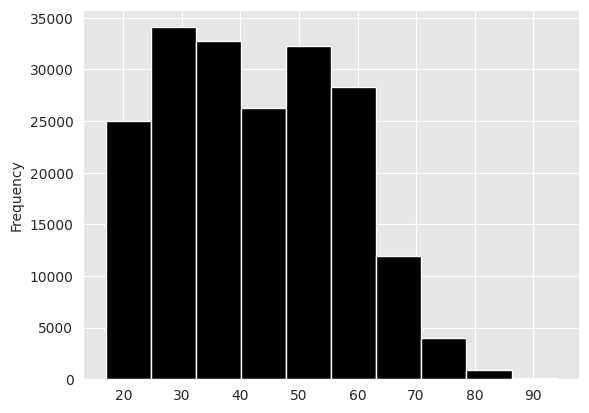

In [23]:
# Create 10 bins to analyze the age feature
df["AGEP"].plot.hist(bins=10, color="black")
plt.show()

You might have expected a lognormal or normal distribution (with peak at around 45 years), but you actually see something that looks like a bimodal distribution with a cutoff at about 16 years. The cutoff occurs because the `adult_filter` was applied when the dataset was loaded. This was done to mimic the [UCI adult dataset](https://archive-beta.ics.uci.edu/dataset/20/census+income).

The double peak could indicate that the dataset has two different subpopulations. Again, you might want to overlay another feature to check this. 

Because you are working with numerical data now, you need to use `.displot()` to create the overlay. You can specify a lot of things, such as whether you want percentages, absolute counts, or stacked bars or bars displayed next to one another. For more information, see [seaborn.displot](https://seaborn.pydata.org/generated/seaborn.displot.html) in the Seaborn documentation.

This plotting method provides access to different types of histogram plots: 
- **hist:** Histogram; instance counts per bin
- **kde:** Kernel density estimation
- **ecdf:** Empirical cumulative distributions

For more information about the methods, see [Visualizing Distributions of Data](https://seaborn.pydata.org/tutorial/distributions.html) in the Seaborn documentation.

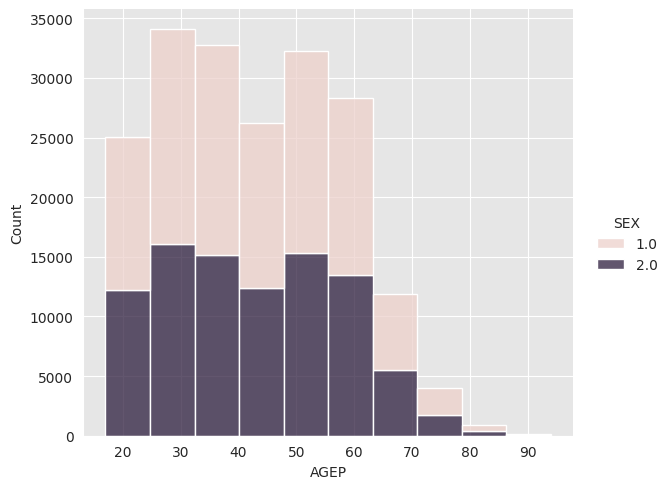

In [24]:
sns.displot(
    df,
    x="AGEP",
    hue="SEX",
    aspect=1.2,
    kind="hist",
    stat="count",
    bins=10,
    multiple="stack",
)
plt.show()

This visualization is not entirely conclusive. You can observe similar patterns for both types of sex that are recorded in the data. This raises the question of whether a combination of attributes lead to the bimodal peaks.

You can also bin the age feature and split the plot by the model target. You would expect the younger age groups to have lower salaries because they are more likely to still be in school or working lower-salary jobs. To plot this, you can include a `col` parameter in `displot()`.

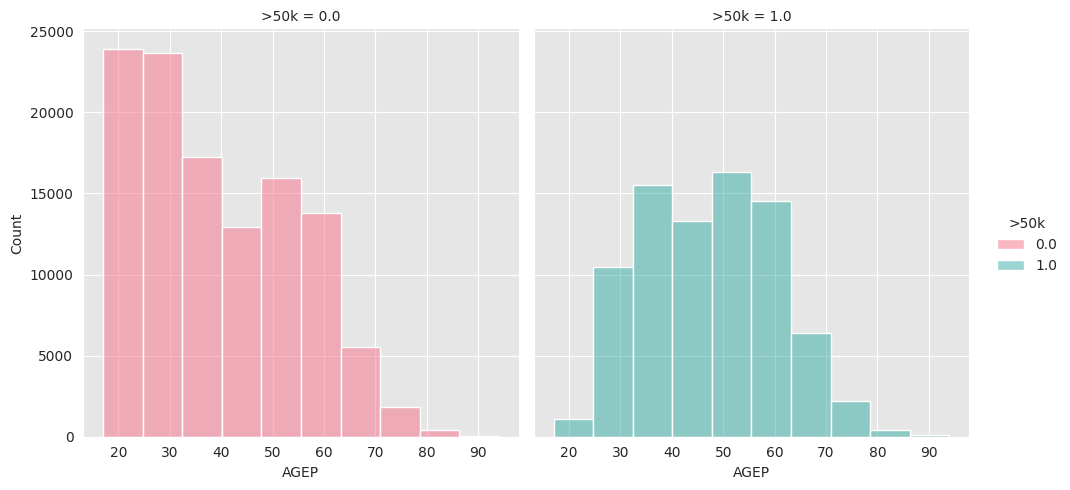

In [25]:
sns.displot(
    df,
    x="AGEP",
    col=model_target,
    bins=10,
    palette=sns.color_palette("husl", 2),
    hue=model_target,
)

plt.show()

These plots are interesting because they suggest that different outcome classes have different underlying age distributions.

You can look at this again by using the kernel density estimate option for plotting.

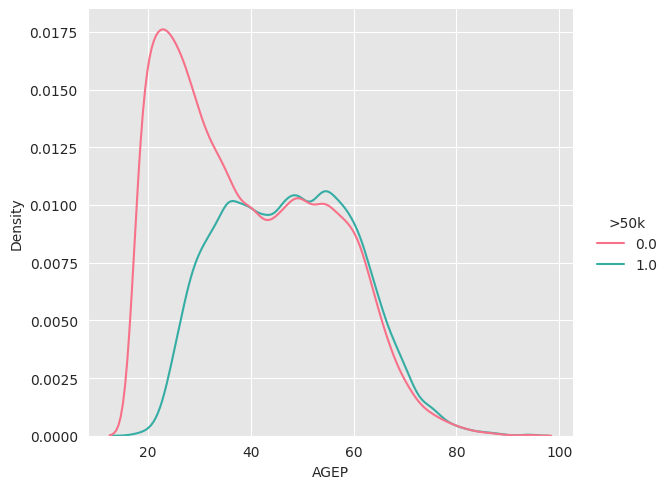

In [26]:
sns.displot(
    df,
    x="AGEP",
    hue=model_target,
    aspect=1.2,
    kind="kde",
    palette=sns.color_palette("husl", 2),
)
plt.show()

---
## Scatterplots

Scatterplots are simple 2D plots of two numerical variables. You can use scatterplots to examine the relationship between two numerical variables. If both variables are moving up, it is a positive correlation. If one variable moves down and the other moves up, it is a negative correlation.

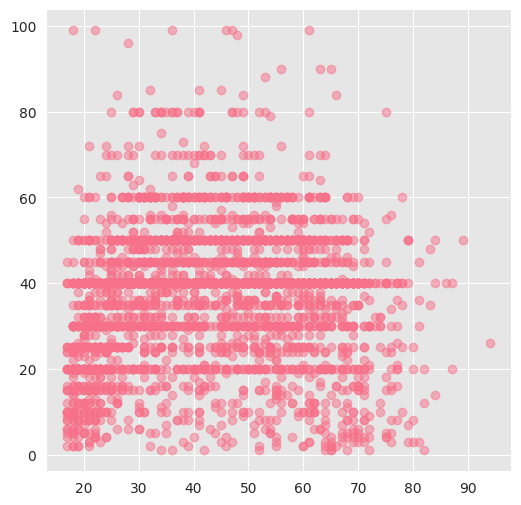

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(
    x="AGEP",
    y="WKHP",
    data=df.sample(
        5000, random_state=1
    ),  # Take a sample of data for quicker plotting
    alpha=0.5,
)
plt.show()

This plot shows that a relationship doesn't really exist. Try overlaying the outcome with a sensitive attribute by specifying a `hue`.

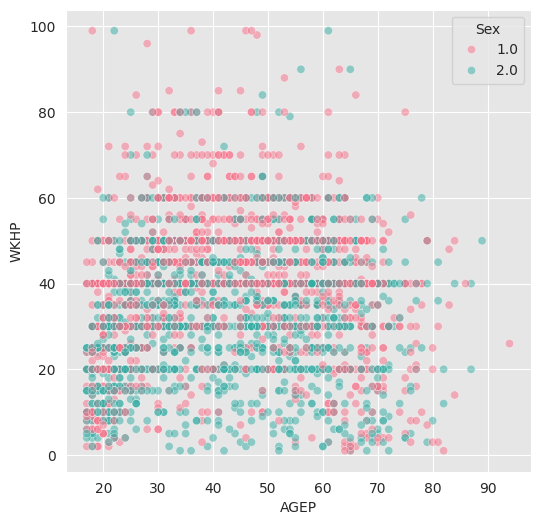

In [28]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df.sample(
        5000, random_state=1
    ),  # Take a sample of data for quicker plotting
    x="AGEP",
    y="WKHP",
    hue="SEX",
    palette=sns.color_palette("husl", 2),
    alpha=0.5,
)

# Add legend
plt.legend(title="Sex", loc='upper right')
plt.show()

Now you can start to see a pattern for the different SEX attributes, with class 1 appearing in the top half of the chart. The original goal was to look at the data split by RAC1P, and you can now see a second pattern emerging for another attribute (SEX).

You can generally expect these effects to intersect, which leads to amplified adverse effects for subpopulations with multiple sensitive attributes. Ultimately, you want to build ML models that work for all subgroups. This plot highlights why it is important to check whether data has multiple sensitive attributes that are related to the outcome. In this particular case, you expect a correlation between hours worked and income, so you will quantify this in the next section.

---
## Correlation matrices

Similar to scatterplots, a correlation matrix aims to pinpoint relationships between numerical features. Correlation values of -1 means perfect negative correlation, 1 means perfect positive correlation, and 0 means that no relationship exists between the two numerical features.

Text(0.5, 1.0, 'Correlation Matrix')

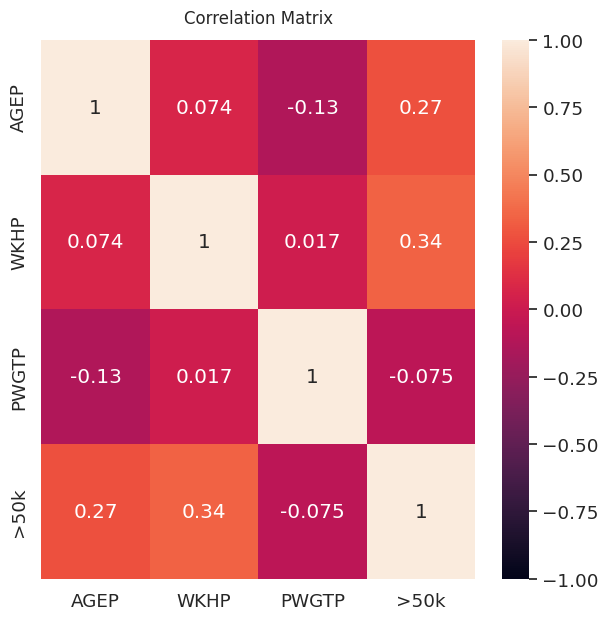

In [29]:
# Set the font size to be larger and the size of the plot to be bigger
sns.set(font_scale=1.2)
plt.figure(figsize = (7,7))

# Create the heatmap and plot it
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlation Matrix", fontdict={"fontsize": 12}, pad=12)

As expected, you see a positive correlation between age and salary as well as between hours worked and salary. However, does this also hold true if you split by the sensitive feature?

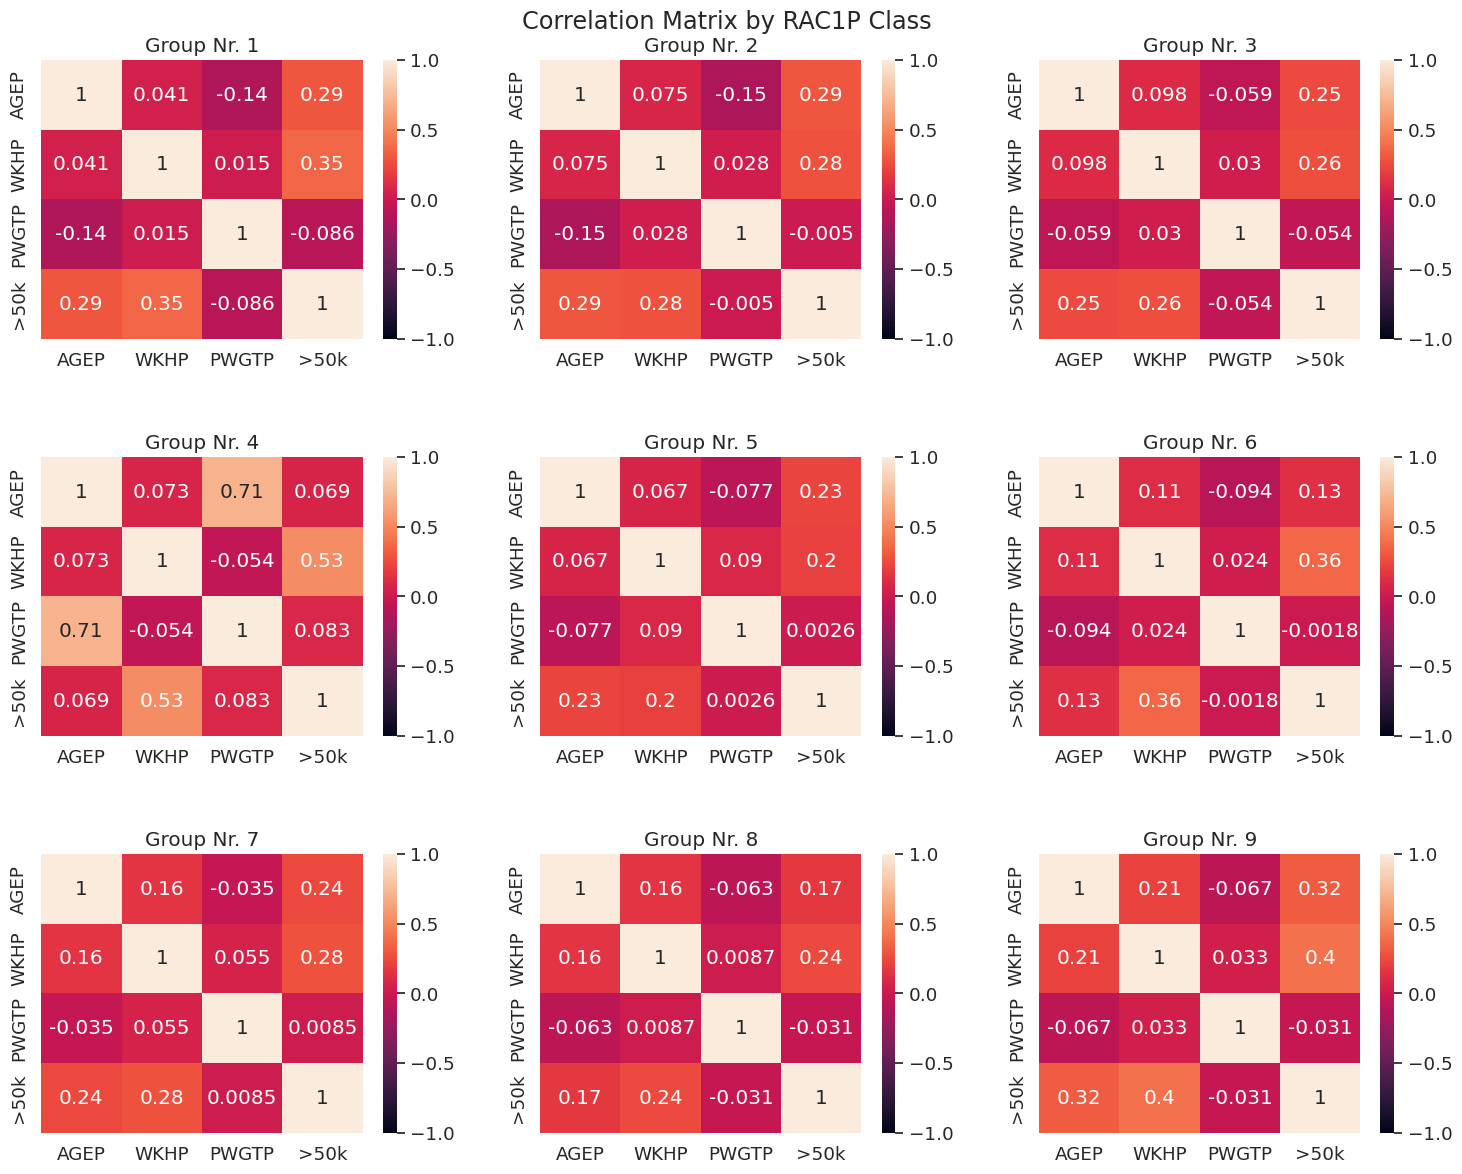

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Correlation Matrix by RAC1P Class")
plt.tight_layout(h_pad=4, w_pad=2)

tickers = sorted(df["RAC1P"].unique())
for i, ax in zip(tickers, axs.ravel()):
    sns.heatmap(
        df[df["RAC1P"] == i].drop(["GCL","RAC1P"], axis=1).corr(numeric_only=True),
        ax=ax,
        vmin=-1,
        vmax=1,
        annot=True,
    )
    ax.set_title("Group Nr. %s" % str(int(i)))

Interestingly, age is less correlated with the outcome for certain groups. This could indicate that being a member of a particular group has a bigger influence on the outcome than the age feature.

---
## DPL and CI
In this section, you will look at some specific measures that can help identify bias in a dataset.

### DPL

The difference in proportion of labels (DPL) compares the proportion of observed outcomes with positive labels for different groups in a dataset. For more information, see [Difference in Proportions of Labels (DPL)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-true-label-imbalance.html) in the *Amazon SageMaker Developer Guide*.

$ \Large DPL = \frac{n_{>50k \wedge RAC1P=6}}{n_{RAC1P=6}} - \frac{n_{>50k \wedge RAC1P=8}}{n_{RAC1P=8}} $

To calculate DPL, select two groups that you want to compare. From the analysis at the beginning of this lab, you know that for the feature RAC1P, groups 6 and 8 have the biggest relative difference in outcome, so you want to use those groups for further analysis.

You can calculate DPL for more than two groups by selecting one reference group and then comparing against that particular group. You can also use multiple attributes to establish group membership (such as RAC1P and SEX).

You can slice the DataFrame by using logical conditions:

In [34]:
n_50k_gr6 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 6)])
n_gr6 = len(df[df["RAC1P"] == 6])

n_50k_gr8 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 8)])
n_gr8 = len(df[df["RAC1P"] == 8])

You can now calculate DPL. For binary and multicategory outcomes, the DPL values range over the interval (-1, 1):

- Positive DPL values indicate that having attribute $a$ (for example, group membership "6") has a higher proportion of positive outcomes when compared with not having attribute $a$ (for example, group membership "8").

- Values of DPL near zero indicate a more equal proportion of positive outcomes between groups with different attributes.

- Negative DPL values indicate that not having attribute $a$ has a higher proportion of positive outcomes when compared with having attribute $a$.

In [35]:
dpl = n_50k_gr6 / n_gr6 - n_50k_gr8 / n_gr8
dpl

0.2862397807230931

The DPL is 0.28. This means that members of group 6 have a higher proportion of positive outcomes.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Try to calculate the DPL between group 1 and group 8 in the cell below.
    <br>
    <br>
</div>

In [42]:
# Calculate DPL for group 1 and group 8
############### CODE HERE ###############
n_50k_gr1 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 1)])
n_gr1 = len(df[df["RAC1P"] == 1])

n_50k_gr8 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 8)])
n_gr8 = len(df[df["RAC1P"] == 8])

dpl = n_50k_gr1 / n_gr1 - n_50k_gr8 / n_gr8
dpl

############## END OF CODE ##############

0.2490962739726761

The resulting value should be approximately 0.25. This means that group 1 has a higher proportion of positive outcomes.

### CI (normalized)

Class imbalance (CI) occurs when different group sizes are present in a dataset (groups based on a sensitive attribute or attributes). Here, you don't consider labels (outcomes), and you focus on the group sizes.

$\Large CI_{norm} = \frac{n_{RAC1P=6}-n_{RAC1P=8}} {n_{RAC1P=6}+n_{RAC1P=8}}$

CI values range from -1 to +1:
- Positive CI values indicate that the group with attribute $a$ contains more examples than the other group.
- CI values near 0 indicate that the groups are similar sizes.
- Negative CI values indicate that the group with attribute $a$ contains fewer examples than the other group.

Again, you can use DataFrame slicing to calculate the values. In fact, you can use `n_gr6` and `n_gr8` from the DPL calculation because these are the counts that you need.

In [43]:
ci_norm = (n_gr6 - n_gr8) / (n_gr6 + n_gr8)
ci_norm

0.6829880597222512

---
## Conclusion

In terms of group size imbalance, you can see from the CI metric that this dataset has more examples from group 6 than 8. This will be important to remember for next steps and also for model selection. You will need to specify that the model target is imbalanced and also that the groups that you want to consider are different sizes.

Remember that models generally improve as you provide more data. The same is true for group-specific performance. You are dealing with target imbalance and group imbalance.

**To finish this lab, continue to notebook 2.**